In [ ]:
# Parameters
stormID = "default_id"
plan1_dir = "default/path/to/file.hdf"

In [1]:

import time
print( f'Last Updated: {time.ctime()}')

import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import h5py
import numpy as np
import matplotlib.dates as mdates
from pyproj import CRS
import geopandas as gpd
import tqdm
from shapely.geometry import Point, Polygon, mapping, box
import time
from datetime import datetime
import re
import contextily as ctx
import plotly.graph_objects as go
import itables
import difflib
from IPython.display import display, HTML
from itables import init_notebook_mode, show
import plotly.express as px
from IPython.display import display
from plotly.subplots import make_subplots

itables.options.showIndex = True

warnings.filterwarnings("ignore")




Last Updated: Mon Jul 21 15:18:19 2025


In [143]:

# ### Define functions

# In[4]:


def clean_attr_value(value):
    # If it's a NumPy array with one element, extract the scalar
    if isinstance(value, np.ndarray) and value.size == 1:
        value = value.item()

    # If it's a byte string, decode it
    if isinstance(value, bytes):
        value = value.decode('utf-8')

    return value

def decode_time(raw_time):
    """
    decode time in hdf file.
    """
    times = [datetime.strptime(str(int(t)), '%Y%m%d%H%M') for t in raw_time]
    return times


def find_matching_storm_name(partial_name, storm_list):
    """
    Finds the first matching storm name from a list using a wildcard pattern.
    """
    pattern = re.compile(partial_name.replace('*', '.*'))
    matches = [col for col in storm_list if pattern.match(col)]
    return matches[0] if matches else None


def load_data(plan_file):
    return h5py.File(plan_file, 'r')

def get_model_info(data):
    """
    load name of the 2D perimeter in the model.
    """
    model_info_name = data['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/'].keys()
    for mdl_inf_nm in model_info_name:
        return mdl_inf_nm

def plot_ts(df_wse_model1,df_wse_model2,check_cell_id):
     #check_cell_id = 357608
     plt.figure()
     df_wse_model1[check_cell_id].plot(c='k',label='windows')
     df_wse_model2[check_cell_id].plot(c='r',label='linux')
     plt.legend()



def extract_geometry(data, mdl_inf_nm):
    """
    extract model geometry variables.
    """
    geo = data.get('Geometry')
    model_units = geo.attrs['SI Units'].decode("utf-8")
    projcs_string = data.attrs['Projection'].decode("utf-8")
    model_prj_epsg = CRS.from_wkt(projcs_string)
    epsg_code = model_prj_epsg.to_epsg()
    geom_xy = geo.get('2D Flow Areas').get(mdl_inf_nm).get('Cells Center Coordinate')[:, :]
    cell_surface_area = geo.get('2D Flow Areas').get(mdl_inf_nm).get('Cells Surface Area')[:]

    x, y = geom_xy[:, 0], geom_xy[:, 1]
    return x, y,model_prj_epsg, epsg_code, cell_surface_area


def create_geodataframe(x, y, epsg_code,cell_surface_area):
    """
    converts model attributes into a geodataframe.
    """
    model_cells = pd.DataFrame({'x': x, 'y': y})
    model_gdf = gpd.GeoDataFrame(model_cells.index, crs=epsg_code, geometry=gpd.points_from_xy(x=model_cells.x, y=model_cells.y))
    model_gdf.columns = ['CellNum', 'geometry'] 
    # Adding Cell surface area to compute cell average size
    model_gdf['surface_area'] = cell_surface_area
    model_gdf['surface_area'] = model_gdf['surface_area'].astype(float)

    return model_gdf

def create_domain_polygon(x, y):
    """
    converts min max coordinates of mesh to a bounding box object.
    """
    coords = [(x.min(), y.max()), (x.max(), y.max()), (x.max(), y.min()), (x.min(), y.min())]
    ras_domain_poly1 = Polygon(coords)
    ras_domain_poly = Polygon(ras_domain_poly1.buffer(1.0 * 7500))
    return ras_domain_poly

def extract_boundary_conditions(data, mdl_inf_nm):
    """
    extracts boundary conditions
    """
    Bnd_cond = data[f'/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/{mdl_inf_nm}/Boundary Conditions']
    boundary_conditions = {kk: Bnd_cond[kk][:] for kk in Bnd_cond.keys()}
    return boundary_conditions

def extract_results_summary(data):
    """
    extract_results_summary
    """
    try:
        Results_summary = data.get('Results').get('Summary').get('Compute Messages (text)')
        Results_text_data = Results_summary[0].decode('utf-8')
        return Results_text_data
    except:
        return 'Result summary not extracted'



def extract_result_field(data, mdl_inf_nm, field_name):
    """
    extract requested variables of model outputs in the results hdf block
    """ 
    try:
        # Define base paths
        base_path = f'/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/{mdl_inf_nm}'
        time_path = '/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series'

        # Extract the field data
        field_data = data[base_path][field_name][:, :]
        df_out = pd.DataFrame(field_data)

        # Extract and parse timestamps
        timesteps = data[time_path]['Time Date Stamp'][:]
        timestamps = pd.to_datetime([t.decode('utf-8') for t in timesteps], format="%d%b%Y %H:%M:%S")
        df_out.index = timestamps

        return df_out

    except Exception as e:
        print(f"!!! ERROR !!! Output not loaded properly: {e}")
        return None



def extract_event_field(data, field_name):
    """
    extract requested variables of model input forcing in the event condition hdf block
    """ 

    base_path = 'Event Conditions'

    if field_name == 'Wind':
        cell_wgts = data[f'{base_path}/Meteorology/Wind/2D Flow Areas/PERIMTER1/Cell Weights'][:]
        ts = data[f'{base_path}/Meteorology/Wind/Timestamp'][:]
        vx = data[f'{base_path}/Meteorology/Wind/VX'][:]
        vy = data[f'{base_path}/Meteorology/Wind/VY'][:]
        return cell_wgts, ts, vx, vy

    elif field_name == 'Air Density':
        air_value = data[f'{base_path}/Meteorology/Air Density/Values'][:]
        return air_value

    elif field_name == 'Boundary Conditions':
        unsteady_path = data.get(base_path).get('Unsteady').get('Boundary Conditions')
        bc_name_nd = list(unsteady_path.get('Normal Depths').keys())[0]
        nd_value = unsteady_path.get('Normal Depths').get(bc_name_nd)[:]

        bc_name_stage = list(unsteady_path.get('Stage Hydrographs').keys())[0]
        stage_value = unsteady_path.get('Stage Hydrographs').get(bc_name_stage)[:]
        stage_bc_table = pd.DataFrame(stage_value)

        return nd_value, stage_bc_table

    elif field_name == 'Initial Conditions':
        ic_path = data.get(base_path).get('Unsteady').get('Initial Conditions')
        ic_vals = ic_path.get('IC Point Elevations')[:]
        ic_position = ic_path.get('IC Point Fixed')[:]
        ic_names = ic_path.get('IC Point Names')[:]

        ic_table = pd.DataFrame(ic_names.astype(str))
        ic_table['Elevation'] = ic_vals.astype(float).round(2)
        ic_table['Fixed'] = ic_position
        ic_table = ic_table.set_index(0)
        ic_table.index.names = ['Name']

        return ic_table

    else:
        print(f"Field '{field_name}' is not defined.")
        return None



def list_hdf_result_fields(data, mdl_inf_nm):
   available_fields_hdf = data[f'/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/{mdl_inf_nm}'].keys()
   return  list(available_fields_hdf)

def list_hdf_eventcondition_fields(data, mdl_inf_nm):
   available_fields_met = list(data['Event Conditions/Meteorology'].keys())
   available_fields_unsteady = list(data['Event Conditions/Unsteady'].keys())

   print(f'Available Meteorology fields in hdf file:\n{available_fields_met}')
   print(f'Available Unsteady fields in hdf file:\n{available_fields_unsteady}')

   return None





def extract_compute_log(lines):
    # Initialize variables
    extracting = False
    selected_lines = []

    # Loop through the lines and extract the desired section
    for line in lines:
        if start_marker in line:
            extracting = True
        if extracting:
            selected_lines.append(line)
        if end_marker in line:
            break

    # Display the extracted lines
    extracted_text = ''.join(selected_lines)
    #print(extracted_text)
    return extracted_text



def extract_error(text):
    # Extract the values using regular expressions
    acre_feet_match = re.search(r'Overall Volume Accounting Error in Acre Feet:\s+([\d.]+)', text)
    percentage_match = re.search(r'Overall Volume Accounting Error as percentage:\s+([\d.]+)', text)

    # Store the values in variables
    acre_feet_error = float(acre_feet_match.group(1)) if acre_feet_match else None
    percentage_error = float(percentage_match.group(1)) if percentage_match else None

    # Output the extracted values
    acre_feet_error, percentage_error
    return acre_feet_error, percentage_error


def get_compute_dataframe(lines):
    data = []
    for line in lines:
        match = re.match(r'(\d{2}[A-Z]{3}\d{4} \d{2}:\d{2}:\d{2})\s+PERIMTER1\tCell #\t\s+(\d+)\t\s+([\d.]+)\t\s+([\d.]+)\t(\d+)', line)
        if match:
            dt_str, cell, wsel, error, iterations = match.groups()
            dt = datetime.strptime(dt_str, '%d%b%Y %H:%M:%S')
            data.append([dt, int(cell), float(wsel), float(error), int(iterations)])

    # Create DataFrame
    df = pd.DataFrame(data, columns=['Datetime', 'Cell', 'WSEL', 'ERROR', 'ITERATIONS'])
    df = df.set_index('Datetime')
    df.index = pd.to_datetime(df.index)


    return df



def read_solver_cores_warmups (file_path,stormID):
    with open(file_path, 'r') as file:
        content = file.read()

        if 'HDF_ERROR trying to close HDF output file' in content:
            # model didnot run possibly
            df= pd.DataFrame([0]*14)
            df.index = df_major.index
            df.loc['StormID',:] = [stormID]
            df.loc['Status',:] = ['HDF Error']

            df_major[stormid] = df


        content_list = content.split('\n') 
        # find info from start
        content_start =  content_list[:25]
        data_lines = [line.strip() for line in content_start if line.strip() and not line.strip().startswith("PROGRESS=")]

        # Initialize dictionary to store extracted values       
        extracted_data = {}

        timesteps = None
        solver_cores = None

        for line in data_lines:
            if 'Number of warm up time steps' in line:
                timesteps = int(line.split(':')[-1].strip())
            elif '2D number of Solver Cores' in line:
                solver_cores = int(line.split(':')[-1].strip())
        # fill info
        extracted_data['StormID'] = stormID
        extracted_data['Solver_cores'] = solver_cores
        extracted_data['Warm up time steps'] = timesteps

        return extracted_data


def h5tree_view(file, include_keys=None):
    """Display selected HDF5 groups in tree-like format.

    Parameters
    ----------
    file : h5py.File
        Opened HDF5 file.
    include_keys : list or None
        List of top-level keys to include (e.g., ['Results', 'Outputs']).
        If None, shows all.
    """
    import h5py
    assert isinstance(file, h5py._hl.files.File)

    def view_h5attributes(obj, depth=0):
        atts = obj.attrs
        deep = "│   " * depth
        for i, k in enumerate(atts.keys()):
            d = deep + ("└──" if i == len(atts)-1 else "├──")
            try:
                if k in ['Faces','Times']:
                    continue
                else:
                    print(d, f'🏷️{k} = `{atts[k].decode("utf-8")}`')
            except (UnicodeDecodeError, AttributeError):
                if k in ['Faces','Times']:
                    continue
                else:
                    print(d, f'🏷️{k} = `{atts[k]}`')

    def view_h5object(obj, depth=0):
        name = obj.name.split("/")[-1]
        deep = "│   " * depth + "├──"
        if isinstance(obj, h5py.Group):
            print(deep, f"📁{name}")
            view_h5attributes(obj, depth=depth + 1)
            for k in obj:
                view_h5object(obj[k], depth=depth + 1)
        else:
            print(deep, f"🔢{name} ⚙️{obj.shape}{obj.dtype}")
            view_h5attributes(obj, depth=depth + 1)

    print(".", file.filename)
    keys_to_view = include_keys if include_keys else list(file.keys())
    for k in keys_to_view:
        if k in file:
            view_h5object(file[k], depth=0)
        else:
            print(f"❌ Key '{k}' not found in file.")


substrings_to_remove = ['PROGRESS=', 'SIMTIME=', 'ABSDATE=', 'ABSTIME=', 'ITER2D=']


In [157]:

# ### RAS Model Outputs Working directories

# In[5]:




epsg_code_default = 6438
# model_cells_shapefile = r'V:/projects/p00860_coj_2023_cf_jf/01_processing/Baseline_Runs/full_model/Shapes/Model2DCells.shp'


# ------------------- STORM 453 [CONTAINER VS TEST] --------------


#scenario naming
model1_name='COJ'


plan1_id = '01'

# stormID='S0453'
# plan1_dir = r'V:\projects\p00860_coj_2023_cf_jf\01_processing\Baseline_Runs\base_model_no_infiltration\COJCOMPOUNDCOMPUTET.p01.hdf'




print(f'\n-----------------\nStormID : {stormID}\n-----------------')

print(f'plan1 dir : {plan1_dir}')


-----------------
StormID : default_id
-----------------
plan1 dir : default/path/to/file.hdf


In [141]:

# # ### Loads Model shapefile

# # In[ ]:


# # Model Cells shapefile
# poly_gdf = gpd.read_file(model_cells_shapefile)
# minx, miny, maxx, maxy = poly_gdf.to_crs(4326).total_bounds
# extent_polygon = box(minx, miny, maxx, maxy)
# coj_extent = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[extent_polygon])

# model_boundary = poly_gdf.dissolve()
# model_boundary = model_boundary.to_crs(epsg_code_default)


# #print(poly_gdf.head())


# # ### Model Domain 

# # In[ ]:


# fig, ax = plt.subplots(1, 1, figsize=(6,8))

# model_boundary.boundary.plot(ax=ax,color='red',label='COJ Model Domain')
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik,crs=epsg_code_default)
# plt.legend()
# ax.set_aspect('auto')
# plt.tight_layout()


### Load RAS model info

In [142]:

# =============================================================================
#  load RAS model info
# =============================================================================

try:
    # load hdf data
    data1 = load_data(plan1_dir)
    mdl_name1 = get_model_info(data1)
    print(f'\n----------\n{stormID}: Model loaded for {model1_name}\nFile path used: {data1.filename}\n----------\n') 
except:
    print(f'\n----------\n!!! {stormID}: Model not loaded for {model1_name}') 




# getting the model geometry
x, y, model_prj_epsg, epsg_code, cell_surface_area = extract_geometry(data1, mdl_name1)
model_gdf = create_geodataframe(x, y, epsg_code,cell_surface_area)


# =============================================================================
#  get reference points
# =============================================================================

reference_points = data1['Geometry/Reference Points/Attributes'][:]
reference_coordinates = data1['Geometry/Reference Points/Points'][:]


# Extract the cell indices
gage_cell_indices = [entry[2] for entry in reference_points]

# Create a DataFrame
df = pd.DataFrame(reference_points, columns=['Name', 'SA/2D', 'Cell Index', 'USXSID', 'DSXSID', 'US Fraction'])

# Decode byte strings
df['Name'] = df['Name'].str.decode('utf-8')
df['SA/2D'] = df['SA/2D'].str.decode('utf-8')

# Add coordinates
df['X'] = [coord[0] for coord in reference_coordinates]
df['Y'] = [coord[1] for coord in reference_coordinates]

# Create geometry column
geometry = [Point(xy) for xy in zip(df['X'], df['Y'])]

# Create GeoDataFrame
gdf_reference = gpd.GeoDataFrame(df, geometry=geometry)

print('Reference Points found in Geometry Data:\n')
show(gdf_reference, lengthMenu=[len(gdf_reference)])


----------
S0453: Model loaded for COJ
File path used: V:\projects\p00860_coj_2023_cf_jf\01_processing\Baseline_Runs\base_model_no_infiltration\COJCOMPOUNDCOMPUTET.p01.hdf
----------

Reference Points found in Geometry Data:



Loading ITables v2.4.2 from the internet... (need help?)


In [85]:

# # Open the HDF5 file in read/write mode
# with h5py.File(plan1_dir, 'r') as hdf:
#     # List all datasets in the file
#     def find_datasets(name, obj):
#         if isinstance(obj, h5py.Dataset):
#             print(name)

#     print("Datasets in the file:")
#     hdf.visititems(find_datasets)



# with h5py.File(plan1_dir, 'r') as f:
#     #print(f.keys())
#     h5tree_view(f, include_keys=['Plan Data']) #,'Results


### Identify output fields 

In [84]:

list_hdf_result_fields(data1, mdl_name1)



['2D Hyd Conn',
 'Boundary Conditions',
 'Cell Flow Balance',
 'Cell Velocity - Velocity X',
 'Cell Velocity - Velocity Y',
 'Cell Volume',
 'Computations',
 "Face Manning's n",
 'Face Velocity',
 'Reference Points',
 'Water Surface']

### Plan Information


In [86]:

plan1_info = {
    k: clean_attr_value(v)
    for k, v in data1['Plan Data/Plan Information'].attrs.items()
}


_plan1 = pd.DataFrame(plan1_info.items()).set_index(0)

plan_info = pd.DataFrame(index = _plan1.index)
plan_info[f'{model1_name}-plan_info']=_plan1[1]
plan_info.index.names = ['Plan Information']


show(plan_info, lengthMenu=[len(plan_info)])


Loading ITables v2.4.2 from the internet... (need help?)


### Plan parameters

In [87]:


plan1_param_keys = {
    k: clean_attr_value(v)
    for k, v in data1['Plan Data/Plan Parameters'].attrs.items()
}



plan1_params = pd.DataFrame(plan1_param_keys.items()).set_index(0)

params_compare = pd.DataFrame(index = plan1_params.index)
params_compare[f'{model1_name}-plan_parameters']=plan1_params[1]
params_compare.index.names = ['Parameter Name']


show(params_compare, lengthMenu=[len(params_compare)])

Loading ITables v2.4.2 from the internet... (need help?)


### Log file Info

In [146]:
data1['Results/Unsteady/'].keys()


<KeysViewHDF5 ['Geometry Info', 'Output', 'Summary']>

In [152]:

def get_log_table(data):
    wsel_err= data.get('Results/Unsteady/Output/Output Blocks/Computation Block/2D Global/2D Iteration Error')[:]
    compute_time = data.get('Results/Unsteady/Output/Output Blocks/Computation Block/Global/Time Date Stamp (ms)')[:]#.decode('utf-8')
    iteration_block = data.get('Results/Unsteady/Output/Output Blocks/Computation Block/2D Global/2D Iterations')[:]


    compute_ = pd.DataFrame(iteration_block)
    compute_.columns = ['Number of Iterations' ,'2D Area pointer','Cell #']

    compute_.index = compute_time
    compute_['Error']=wsel_err
    return compute_
    #print(compute_)


# print(get_log_table(data1))
# print(get_log_table(data2))


# Computations 
try:
    plan1_volume_keys = {
        k: clean_attr_value(v)
        for k, v in data1['Results/Unsteady/Summary/Volume Accounting'].attrs.items()
    }
    
    # print('Plan1:')
    # print(pd.DataFrame(plan1_volume_keys.items()))
    
    _log1 = pd.DataFrame(plan1_volume_keys.items()).set_index(0)
    
    log_info = pd.DataFrame(index = _log1.index)
    log_info[f'{model1_name}']=_log1[1]
    
    log_info.index.names = ['Log Information']
    
    
    
    show(log_info, lengthMenu=[len(log_info)])
except:
    print(f"No Volume Accounting data: {data1['Results/Unsteady/Summary'].keys()}\ndata1['Results/Unsteady/Summary/Volume Accounting']") 
    

No Volume Accounting data: <KeysViewHDF5 []>
data1['Results/Unsteady/Summary/Volume Accounting']


## Extract Outputs

### Water Surface Elevation

In [153]:

df_wse_model1 = extract_result_field(data1,mdl_name1,'Water Surface')

# along timeseries and then the max
model_gdf['max_wse'] = df_wse_model1.max() 

summary_table_wse = model_gdf['max_wse'].describe().to_frame(name='max WSE')
# display(summary_table_wse)

### Analyze flood depths

In [154]:

print('''
flood depth timeseries = Modeled WSE at all times - Modeled WSE at time 0

max flood depth = maximum of flood depth timeseries

flood depth difference = max flood depth model1 - max flood depth model2
''')


fdepth1 = df_wse_model1-df_wse_model1.iloc[0]

max_fdepth1 = fdepth1.max()


model_gdf['fdepth1'] = max_fdepth1


summary_table_fdep = model_gdf['fdepth1'].describe().to_frame(name='max Flood Depth')
# display(summary_table_fdep)


flood depth timeseries = Modeled WSE at all times - Modeled WSE at time 0

max flood depth = maximum of flood depth timeseries

flood depth difference = max flood depth model1 - max flood depth model2



### Velocity

In [155]:

# load velocities
df_velx = extract_result_field(data1,mdl_name1,'Cell Velocity - Velocity X')
df_vely = extract_result_field(data1,mdl_name1,'Cell Velocity - Velocity Y')

df_vel = np.sqrt(df_velx**2 + df_vely**2)


# along timeseries and then the max
model_gdf['max_vel'] = df_vel.max() 

summary_table_vel = model_gdf['max_vel'].describe().to_frame(name='max Vel')
# display(summary_table_vel)

### Cell Flow Balance

In [128]:
df_flowbalance = extract_result_field(data1,mdl_name1,'Cell Flow Balance')

model_gdf['max_flowbalance'] = df_flowbalance.max() 

summary_table_flow_bal = model_gdf['max_flowbalance'].describe().to_frame(name='max Flow Balance')
# display(summary_table_flow_bal)


### Cell Volume 

In [129]:
df_volume = extract_result_field(data1,mdl_name1,'Cell Volume')

model_gdf['max_vol'] = df_volume.max() 

summary_table_vol = model_gdf['max_vol'].describe().to_frame(name='max Volume')
# display(summary_table_vol)

### Summary Statistics of Model Output Maximum Values

In [131]:

# Combine all summary tables into a single DataFrame
combined_summary_table = pd.concat([
    summary_table_wse,
    summary_table_vel,
    summary_table_fdep,
    summary_table_vol,
    summary_table_flow_bal
], axis=1)

# Display the combined summary table
display(combined_summary_table)





,max WSE [Summary Statistics],max Vel,max Flood Depth,max Volume,max Flow Balance
count,369381.000000,369381.000000,369381.000000,3.693810e+05,369381.000000
mean,28.981964,5.147892,0.378059,3.380085e+05,7.201437
std,29.309504,576.079102,1.087027,6.802726e+06,361.419464
min,-49.750000,0.000000,0.000000,-3.042093e+01,-66.093658
25%,7.468750,0.000000,0.000000,0.000000e+00,0.000000
50%,18.964457,0.000000,0.000000,0.000000e+00,0.000000
75%,38.062500,0.000000,0.000000,0.000000e+00,0.000000
max,327.659271,172589.218750,8.480345,5.577971e+08,172589.218750


## Plot timeseries at Reference Points

### Water Surface Elevation

Text(0.5, 0, 'Time enteries')

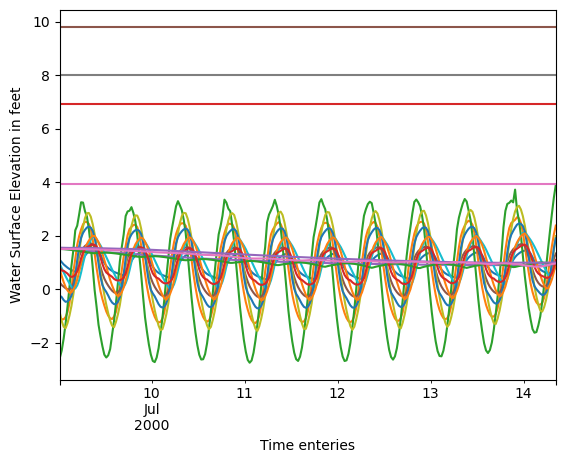

In [132]:
for ids in gdf_reference.index:
    cell_info = gdf_reference.iloc[ids]
    df_wse_model1[cell_info['Cell Index']].plot()

plt.ylabel('Water Surface Elevation in feet')
plt.xlabel('Time enteries')


### Cell Velocity

Text(0.5, 0, 'Time enteries')

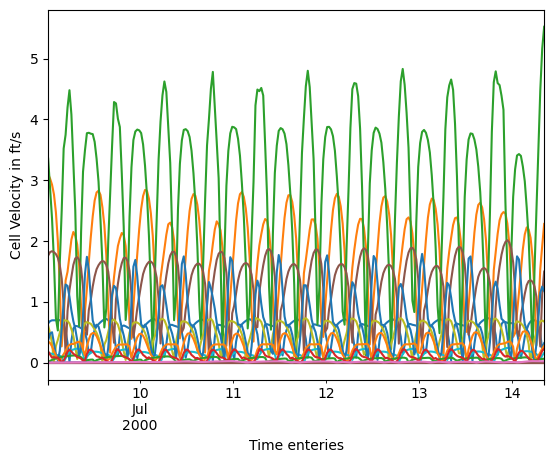

In [133]:
for ids in gdf_reference.index:
    cell_info = gdf_reference.iloc[ids]
    df_vel[cell_info['Cell Index']].plot()

plt.ylabel('Cell Velocity in ft/s')
plt.xlabel('Time enteries')


### Flow Balance

Text(0.5, 0, 'Time enteries')

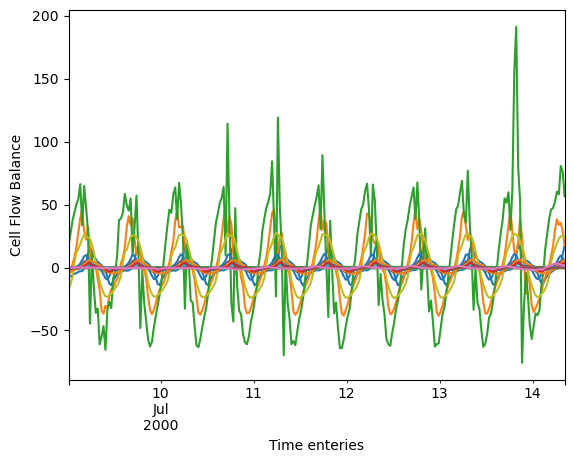

In [134]:
for ids in gdf_reference.index:
    cell_info = gdf_reference.iloc[ids]
    df_flowbalance[cell_info['Cell Index']].plot()

 
plt.ylabel('Cell Flow Balance')
plt.xlabel('Time enteries')       

### Cell Volume

Text(0.5, 0, 'Time enteries')

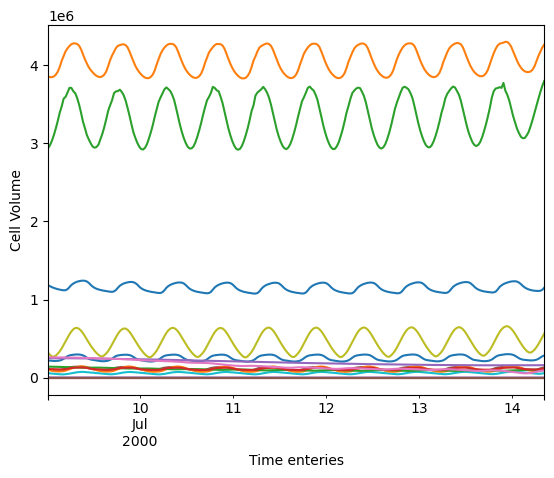

In [135]:
for ids in gdf_reference.index:
    cell_info = gdf_reference.iloc[ids]
    df_volume[cell_info['Cell Index']].plot()

plt.ylabel('Cell Volume')
plt.xlabel('Time enteries')    

## Event Forcings

### Winds

,max Wind [Summary Statistics]
count,2375.000000
mean,42.885452
std,50.742142
min,0.000000
25%,11.753333
50%,16.782833
75%,49.145657
max,167.254791


Text(0.5, 0, 'Time enteries')

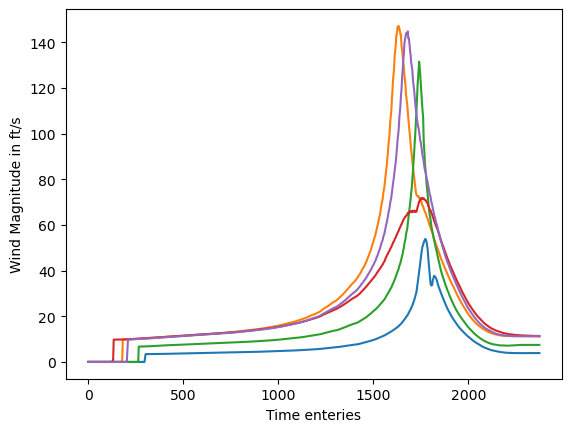

In [136]:
# load event conditions
_,ts1, model1_windx, model1_windy = extract_event_field(data1,'Wind')

df_wind = np.sqrt(model1_windx**2 + model1_windy**2)

df_wind_2d = pd.DataFrame(df_wind)

df_wind_2d_max = df_wind_2d.max(axis=1)


summary_table = df_wind_2d_max.describe().to_frame(name='max Wind [Summary Statistics]')
display(summary_table)

# pick 5 random locations and plot
df_wind_2d_no_nan = df_wind_2d.loc[:, (df_wind_2d != 0).any(axis=0)]
df_wind_2d_sample = df_wind_2d_no_nan.sample(5,axis=1)


for cols in df_wind_2d_sample.columns:
    df_wind_2d_sample[cols].plot()

plt.ylabel('Wind Magnitude in ft/s')
plt.xlabel('Time enteries')

### Boundary Conditions

Normal Depth:
[0.001]
Downstream: Stage Hydrograph:


Text(0.5, 0, 'Time enteries')

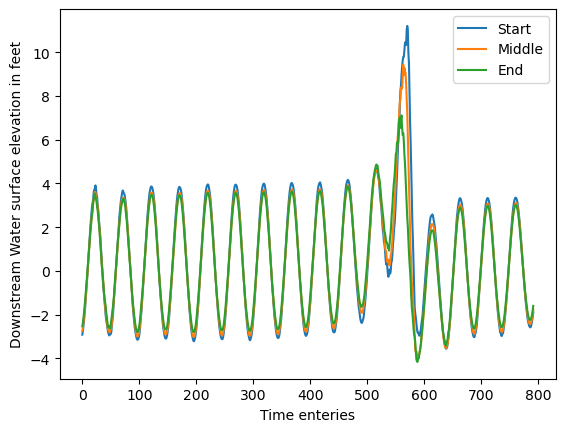

In [137]:

# load boundary stage conditions
model1_ND, model1_BC = extract_event_field(data1,'Boundary Conditions')

print('Normal Depth:')
print(model1_ND)

print('Downstream: Stage Hydrograph:')
# print(model1_BC)


plt.figure()
model1_BC[1].plot(label='Start')
model1_BC[len(model1_BC.columns)/2].plot(label='Middle')
model1_BC[len(model1_BC.columns)-1].plot(label='End')
plt.legend()

plt.ylabel('Downstream Water surface elevation in feet')
plt.xlabel('Time enteries')



In [138]:
# interaction WSE timeseries plot

In [139]:

# for ids in gdf_reference.index:

#     cell_info = gdf_reference.iloc[ids]

    
#     # Interactive time series plot of WSE differences
#     fig_ts = go.Figure()


#     fig_ts.add_trace(go.Scatter(
#         x=df_wse_model1.index,
#         y=df_wse_model1[cell_id],
#         mode='lines',
#         opacity=0.8,
#         name=str(model1_name)
#     ))



#     fig_ts.update_layout(
#         title=f'Timeseries of WSE at Gage: {cell_info['Name']} Cell ID: {cell_info['Cell Index']}\n',
#         xaxis_title='Datetime',
#         yaxis_title='WSE (feet)',
#         height=400,
#         width=1200
#     )

#     # Show plots
#     fig_ts.show()